# Preliminaries

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

C:\Users\Anoshan\AppData\Local\Temp\ipykernel_20712\1588287611.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Data Extraction

In [3]:
path = "./Resources"

# Load a dataset into a Pandas DataFrame
train_proteins = pd.read_csv(path+"/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides = pd.read_csv(path+"/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_clinical = pd.read_csv(path+"/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

In [4]:
print('clinical dataset shape:  ', train_clinical.shape)

clinical dataset shape:   (2615, 8)


In [5]:
# Display the first 5 examples
train_clinical.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [6]:
print('proteins dataset shape:  ', train_proteins.shape)

proteins dataset shape:   (232741, 5)


In [7]:
# Display the first 5 examples
train_proteins.head(5)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [8]:
print('peptides dataset shape:  ', train_peptides.shape)

peptides dataset shape:   (981834, 6)


In [9]:
train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


# Plotting Data

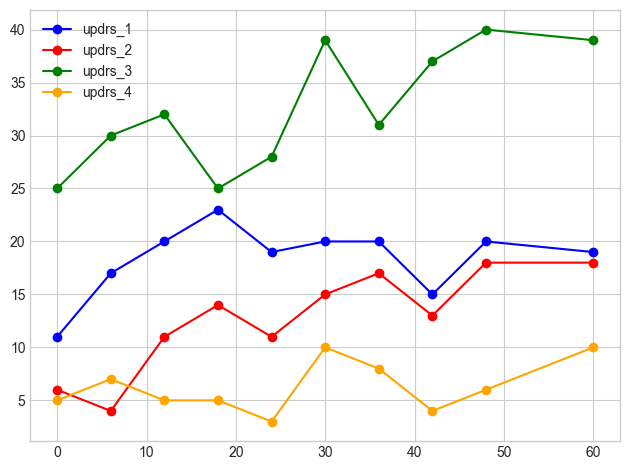

In [10]:
# Fetch data for patient with id 1517
plot_df = train_clinical[train_clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

ax.legend()
plt.show()

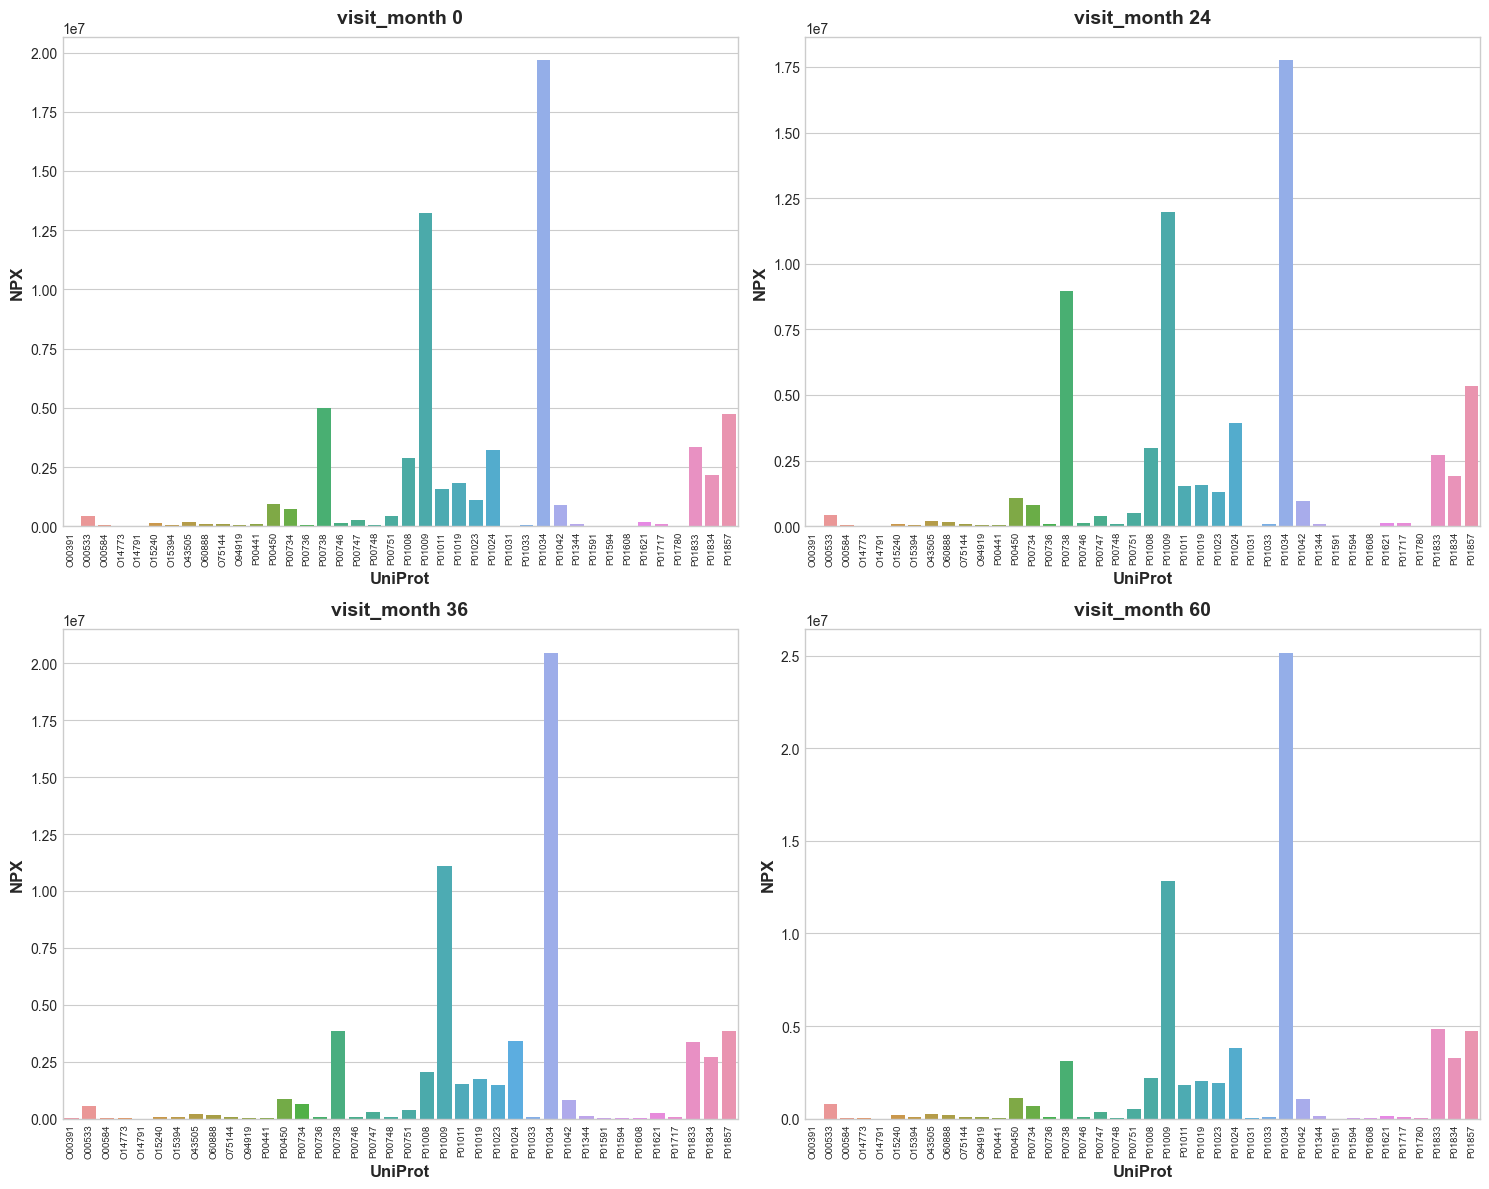

In [13]:
pro_plot_df = train_proteins[train_proteins["patient_id"]==1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len/2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows*6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, month in enumerate(unique_month):
    row = i//2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month']==month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    #bp.set(xticklabels=[])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title('visit_month ' + str(month))
plt.show()

In [14]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df

In [15]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

In [16]:
pro_pep_df.shape

(1113, 1196)

In [17]:
# Display the first 5 examples
pro_pep_df.head(5)

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [52]:
pro_pep_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1100.000000,994.000000,1.022000e+03,977.000000,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215246.833636,9015.134433,3.937256e+06,67866.452927,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,50727.227704,3127.061637,1.677710e+06,61176.002825,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,186658.250000,6899.805000,2.895622e+06,30997.900000,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,217430.500000,8604.345000,3.671010e+06,52576.900000,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246423.500000,10612.775000,4.710635e+06,85369.600000,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000


<AxesSubplot: >

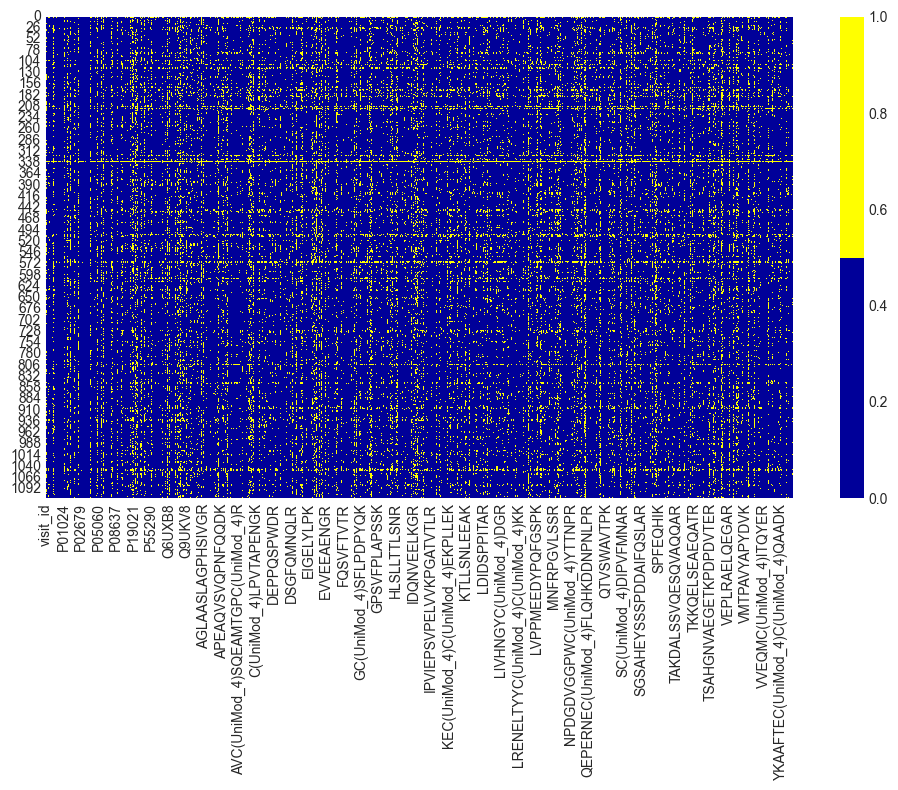

In [51]:
plt.figure(figsize=(10,8))
cols = pro_pep_df.columns
colours = ['#000099', '#ffff00'] # specify colours: yellow - missing. blue - not missing
sns.heatmap(pro_pep_df[cols].isna(), cmap=sns.color_palette(colours))

In [ ]:
# We'll fill missing values with zero

# Change Column Types, Impute Missing Values and Feature Scaling

In [71]:
from sklearn.preprocessing import MinMaxScaler

In [74]:
def clean_data(pro_pep_df):
    # Change column type to category for column: 'visit_id'
    pro_pep_df = pro_pep_df.astype({'visit_id': 'category'})
    
    num_columns = list(pro_pep_df.columns)
    num_columns.remove('visit_id')
    pro_pep_df = pro_pep_df.astype({x: 'float64' for x in num_columns})
    
    # fill missing values of num_columns with zero
    pro_pep_df[num_columns] = pro_pep_df[num_columns].fillna(0)
    
    # scale the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    pro_pep_df[num_columns] = scaler.fit_transform(pro_pep_df[num_columns])
    
    return pro_pep_df

In [75]:
pro_pep_df_cleaned = clean_data(pro_pep_df.copy())

In [76]:
pro_pep_df_cleaned.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,0.426194,0.222648,0.000000,0.000000,0.143887,0.267073,0.136867,0.110022,0.218274,...,0.493425,0.000000,0.317695,0.108693,0.146328,0.304961,0.394589,0.559062,0.000000,0.102931
1,10053_12,0.489856,0.241057,0.000000,0.000000,0.000000,0.000000,0.352933,0.109916,0.214284,...,0.490339,0.000000,0.360994,0.051547,0.089252,0.366078,0.466475,0.478570,0.459633,0.361790
2,10053_18,0.619597,0.280792,0.107573,0.375310,0.000000,0.253694,0.219237,0.118583,0.219292,...,0.538441,0.000000,0.391497,0.054732,0.124481,0.251281,0.485709,0.471845,0.488613,0.303277
3,10138_12,0.589847,0.273706,0.138336,0.416134,0.452879,0.643230,0.275674,0.397079,0.266130,...,0.459488,0.340930,0.281497,0.067630,0.082436,0.357109,0.491871,0.582268,0.612365,0.141058
4,10138_24,0.561900,0.288956,0.067900,0.263051,0.585814,0.284962,0.265934,0.381004,0.314238,...,0.502970,0.230034,0.254181,0.098175,0.124661,0.321713,0.423122,0.000000,0.531408,0.070023


In [77]:
pro_pep_df_cleaned.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,...,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000
mean,0.374077,0.282629,0.395396,0.387445,0.334826,0.271935,0.218566,0.348692,0.254467,0.330007,...,0.518937,0.290969,0.260932,0.083570,0.150324,0.367417,0.466356,0.493628,0.406255,0.233884
std,0.275521,0.130675,0.166291,0.165171,0.163199,0.161419,0.137743,0.173658,0.104718,0.146052,...,0.135347,0.146797,0.139749,0.086239,0.127216,0.120728,0.160571,0.144051,0.168513,0.180854
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.193116,0.294184,0.297869,0.243086,0.190966,0.113308,0.246533,0.185083,0.235989,...,0.452589,0.224911,0.190371,0.030282,0.070901,0.280225,0.374740,0.403312,0.326912,0.052044
50%,0.465491,0.267524,0.398751,0.392349,0.339513,0.278856,0.201048,0.355669,0.242050,0.313838,...,0.527935,0.294933,0.255102,0.066650,0.115521,0.353353,0.463648,0.486524,0.413905,0.242291
75%,0.584117,0.358878,0.499740,0.487087,0.438192,0.369178,0.292022,0.455470,0.312597,0.412518,...,0.600411,0.375071,0.334066,0.112268,0.188352,0.437828,0.564074,0.577826,0.500144,0.349777
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
pro_pep_df_cleaned.to_csv("pro_pep_df_cleaned.csv", index=False)